# Copy Trading

## Import libraries

In [1]:
import pandas as pd
import datetime

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np

sns.set()

## Input

### Load data

In [2]:
df = pd.read_csv("Statistics.csv")

In [3]:
df.columns

Index(['Provider name', 'ID', 'Hotforex url', 'Location', 'Last updated',
       'Message', 'Minimum first deposit', 'Active since', 'Gain',
       'Max Drawdown', 'Leverage', 'Followers', 'Performance Fee',
       'Stability Score', 'Performance', 'Balance', 'Equity',
       'Initial Deposit', 'Total Deposits', 'Total Withdrawals', 'Profit',
       'Number of Closed Trades', 'Number of Open Trades',
       'Positive Closed Trades', 'Negative Closed Trades', 'Profitability',
       'Average Profit', 'Average Loss', 'Average Lot Size',
       'Average Trade Length', 'Activity'],
      dtype='object')

Description:

- **Gain**: A time-weighted return method of calculating investment return. To apply the time-weighted return method, combine the return over sub-periods, by compounding them together, resulting in the overall period return. The rate of return over each different sub-period is weighted according to the duration of the sub-period.

- **Max Drawdown**: Worst losing sequence leading to the largest drop in balance (from the date of account opening).

- **Performance Fee**: The percentage of any profit made on the Follower’s account which is then payable to the Strategy Provider as his reward. Performance fees are paid every other Saturday or at time of withdrawal or unfollowing.

- **Stability Score**: Risk Score is determined by comparing certain performance elements between individual Strategy Providers and all other active Strategy Providers. The elements taken into account are daily volatility on return, trading allocation capital and length of overall trading activity within HFcopy system. Strategy Providers are scored 1 to 5 based on the weighted elements where 5 is the highest divergent performance across all other participating Strategy Providers, making it less stable across the board regardless of market conditions and 1 being less unstable overall.

- **Performace**: Show the results of the trading account. It measures in (%).

- **Profitability**: Percentage of trades closed with positive profits.

- **Average Profit**: Average profit for all profitable closed trades. Sometimes the units in USD or USC (USD cent).

- **Average Loss**: Average loss for all unprofitable closed trades. Sometimes the units in USD or USC (USD cent).

- **Gain**: A time-weighted return method of calculating investment return. To apply the time-weighted return method, combine the return over sub-periods, by compounding them together, resulting in the overall period return. The rate of return over each different sub-period is weighted according to the duration of the sub-period. In order to understand how hotforex makes this calculations, please check this [section](#performance_example).

### Bounds

The objective is to define parameters to bound the analysis.

In [4]:
max_drawdown_limit = 40
num_days_limit = 180

## Exploratory Data Analysis

### "ID" numbers

Extract only ID numbers.

In [5]:
df[['ID']].head()

,ID
0,78013241 • Copy Cent account
1,78026185 • Copy Cent account
2,66167076 • Copy Cent account
3,35430348 • Copy Pro account
4,35382453 • Copy Premium account


In [6]:
# Get Type account
df['Type account'] = df['ID'].apply(lambda x: x.split(' ')[3] if not pd.isnull(x) else "")

# Get ID
df['ID'] = df['ID'].apply(lambda x: x.split(' ')[0] if not pd.isnull(x) else "")

In [7]:
df[['Type account', 'ID']].head()

,Type account,ID
0,Cent,78013241
1,Cent,78026185
2,Cent,66167076
3,Pro,35430348
4,Premium,35382453


### "Active since" and "Last updated"

We need to convert these two columns as datetime object

In [8]:
df[['Active since', 'Last updated']].head()

,Active since,Last updated
0,Active since: 18/01/2024,18/04/2024 01:42:58
1,Active since: 30/03/2024,18/04/2024 01:46:01
2,Active since: 13/10/2023,18/04/2024 01:39:42
3,Active since: 14/03/2024,18/04/2024 01:36:53
4,Active since: 02/05/2023,18/04/2024 01:31:55


In [9]:
# Extract date from "Active since"
df['Active since'] = df['Active since'].apply(lambda x: x.split(' ')[2] if not pd.isnull(x) else "")

In [10]:
# Last updated column. Ignore NaN values
df['Last updated'] = pd.to_datetime(df['Last updated'], format= '%d/%m/%Y %H:%M:%S', errors='coerce')

# Active since column. Ignore NaN values
df['Active since'] = pd.to_datetime(df['Active since'], format= '%d/%m/%Y', errors='coerce')

In [11]:
df[['Last updated', 'Active since']].head()

,Last updated,Active since
0,2024-04-18 01:42:58,2024-01-18
1,2024-04-18 01:46:01,2024-03-30
2,2024-04-18 01:39:42,2023-10-13
3,2024-04-18 01:36:53,2024-03-14
4,2024-04-18 01:31:55,2023-05-02


### Location and Strategies age

In this section, you will filter the data by the number of active days.

In [12]:
# Compute the age of the strategy
df['Active since'].head()

0   2024-01-18
1   2024-03-30
2   2023-10-13
3   2024-03-14
4   2023-05-02
Name: Active since, dtype: datetime64[ns]

In [13]:
# Day when you scraped data
start_date = '2024-04-17'
start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')

In [14]:
# Number of days of the strategies. ".days" attribute extract days from timedelta object
df['Num days strategies'] = (start_date - df.loc[:, 'Active since']).apply(lambda x: x.days) # type: ignore

In [15]:
print(f"Minimum days: {df['Num days strategies'].min()},   Maximum days {df['Num days strategies'].max()}")

Minimum days: 0.0,   Maximum days 1349.0


Select only strategies with a minimun of days on the market. This is a personal criteria.

In [16]:
df_selected = df[df['Num days strategies'] >= num_days_limit].copy()
df_selected.reset_index(drop=True, inplace=True)

In [17]:
print(f"We have {df_selected.shape[0]} strategies with more than {num_days_limit} days.")

We have 235 strategies with more than 180 days.


### Type of account

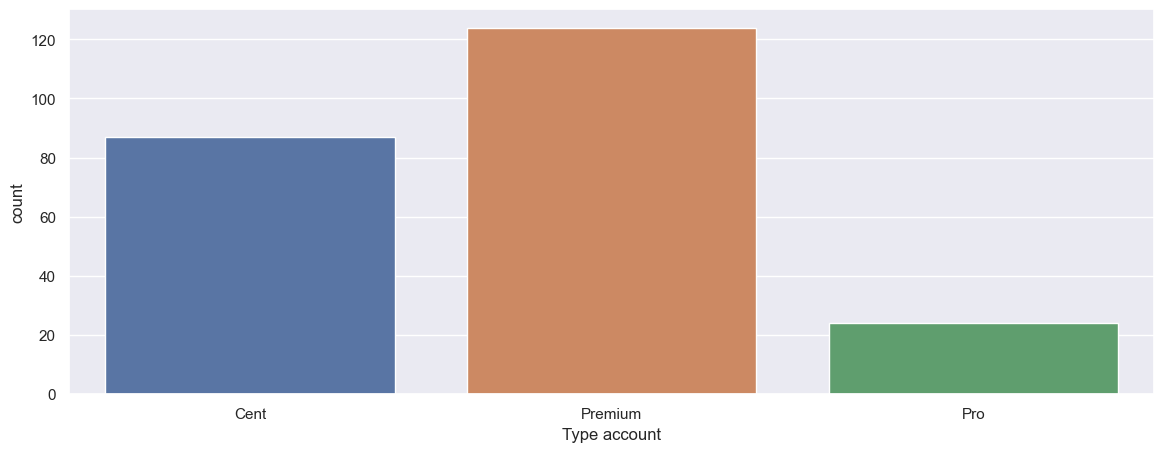

In [18]:
fig, axes = plt.subplots(figsize=(14,5))
bar_plot = sns.countplot(data=df_selected, x='Type account', ax=axes)

There are 3 types of accounts:

- [Cent](https://www.hfm.com/int/en/trading-accounts/cent-account). It allows trade with cent lots (Cent lot = 0,01 of a Standard lot or 1,000 units). It means that you can trade with lower amounts of money. However, you can trade only Forex and Gold.

- [Premium](https://www.hfm.com/int/en/trading-accounts/premium-account). No minimum deposit required and no commission.

- [Pro](https://www.hfm.com/int/en/trading-accounts/pro-account). Low spreads. Minimum deposit = $100.

You can compare the trading accounts [here](https://www.hfm.com/int/en/trading-accounts).

### Equity

In [19]:
# Divide "Equity" value by 100 if the account is type "Cent". All amounts must be USD.

temp_func = lambda x: x['Equity']/100 if x['Type account'] == 'Cent' else x['Equity']

df_selected['Equity'] = df_selected[['Equity', 'Type account']].apply(temp_func, axis=1)

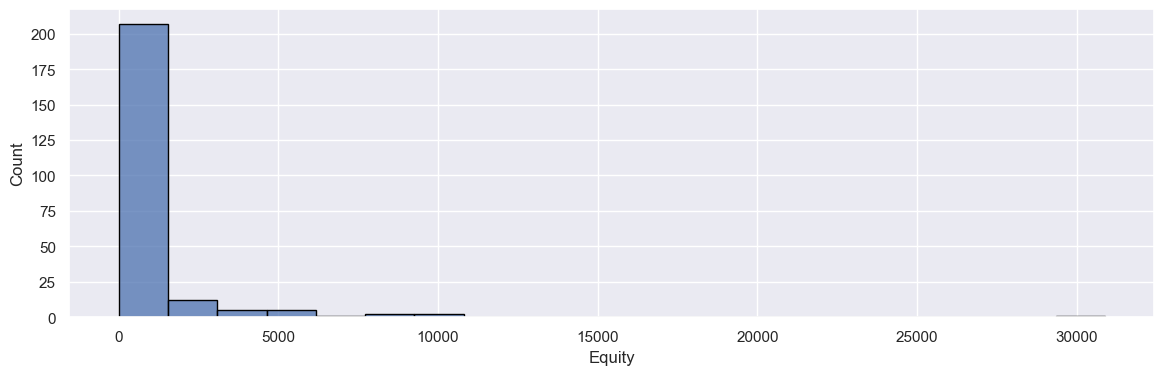

In [20]:
fig, axes = plt.subplots(figsize=(14,4))
sns.histplot(data=df_selected, x='Equity', bins=20, ec='black');

In [21]:
df_selected[df_selected['Equity'] == 0].shape[0]

29

There are 29 strategies with Equity equals to zero. We don't need to analyze these strategies because there are two possible reasons:
- The provider withdraw all of its money.
- The provider went bankrupt.

In [22]:
index_to_drop = df_selected[df_selected['Equity'] == 0].index
df_selected.drop(index_to_drop, axis=0, inplace=True)

# Reset index
df_selected.reset_index(drop=True, inplace=True)

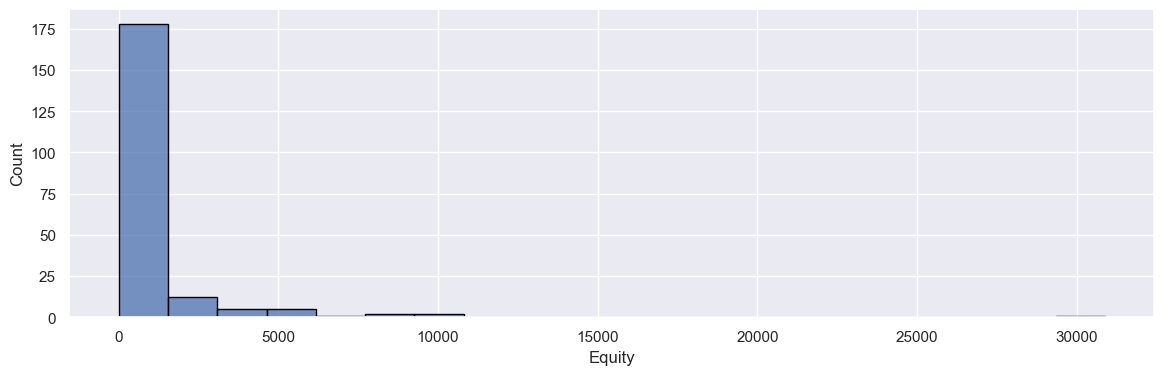

In [23]:
fig, axes = plt.subplots(figsize=(14,4))
sns.histplot(data=df_selected, x='Equity', bins=20, ec='black');

The distribution is very similar after delete strategies with Equity = 0.

In [24]:
df_selected[df_selected['Equity'] <= 1000].shape[0]

163

In [25]:
df_selected[df_selected['Equity'] > 1000].shape[0]

43

- There are 163 providers with an Equity lower than or equals to $1000.
- There are 43 providers with an Equity greater than $1000.

### Minimum First Deposit

In [26]:
df_selected['Minimum first deposit'].head()

0     ¢ 5000
1     $ 25.0
2     $ 25.0
3    ¢ 10000
4    $ 400.0
Name: Minimum first deposit, dtype: object

In [27]:
# Extract only the numbers
df_selected['Minimum first deposit'] = df_selected['Minimum first deposit'].str.split(" ", expand=True)[1]

# Convert as float
df_selected['Minimum first deposit'] = df_selected['Minimum first deposit'].astype(float)

In [28]:
# Divide "Minimum First Deposit" value by 100 if the account is type "Cent". All amounts must be USD

temp_func = lambda x: x['Minimum first deposit']/100 if x['Type account'] == 'Cent' else x['Minimum first deposit']

df_selected['Minimum first deposit'] = df_selected[['Minimum first deposit', 'Type account']].apply(temp_func, axis=1)

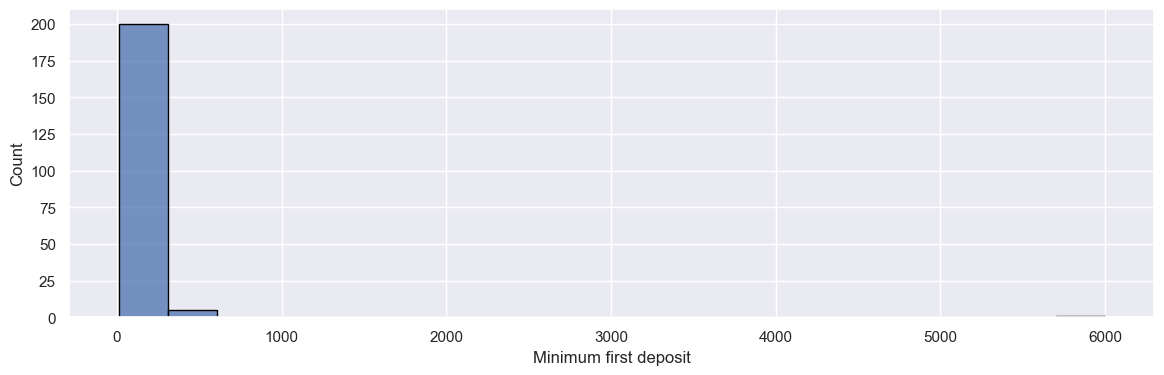

In [29]:
fig, axes = plt.subplots(figsize=(14,4))
sns.histplot(data=df_selected, x='Minimum first deposit', bins=20, ec='black');

In [30]:
df_selected.loc[df_selected['Minimum first deposit'] > 5000]

,Provider name,ID,Hotforex url,Location,Last updated,Message,Minimum first deposit,Active since,Gain,Max Drawdown,...,Positive Closed Trades,Negative Closed Trades,Profitability,Average Profit,Average Loss,Average Lot Size,Average Trade Length,Activity,Type account,Num days strategies
157,Gichboy24,35404313,https://my.hfm.com/en/hfcopy/provider-details....,Kenya,2024-04-18 14:02:43,"""Scalping forex""",6000.0,2023-09-06,-26.1,64.77,...,7153.0,3539.0,66.9,2.42,-5.16,0.03,4H 25m 27s,"{'Symbol': ['GBPCHFr', 'GBPNZDr', 'GBPNZDr', '...",Pro,224.0


There are one strategy with a Minimun First Deposit greater than $5000. I will delete it because for now this amount is too high.

In [31]:
index_to_drop = df_selected[df_selected['Minimum first deposit'] > 5000].index
df_selected.drop(index_to_drop, axis=0, inplace=True)

# Reset index
df_selected.reset_index(drop=True, inplace=True)

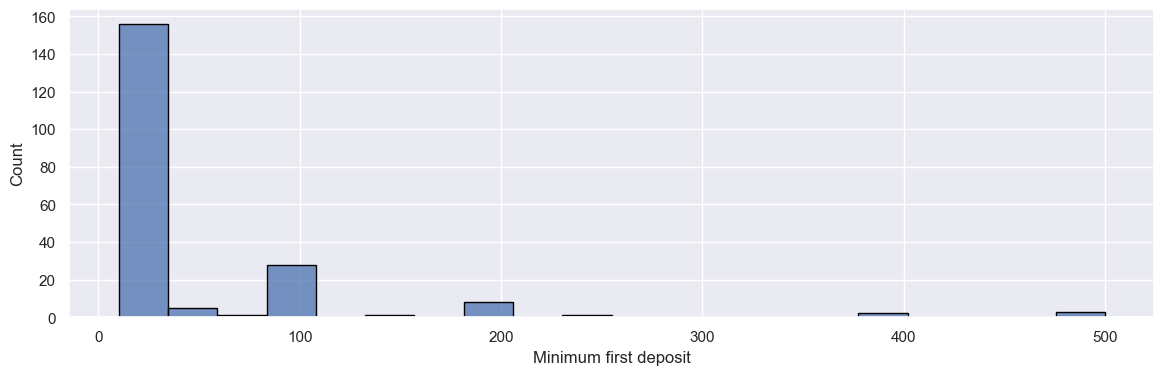

In [32]:
fig, axes = plt.subplots(figsize=(14,4))
sns.histplot(data=df_selected, x='Minimum first deposit', bins=20, ec='black');

The requirement of most of the strategies is $25.

### Max Drawdown

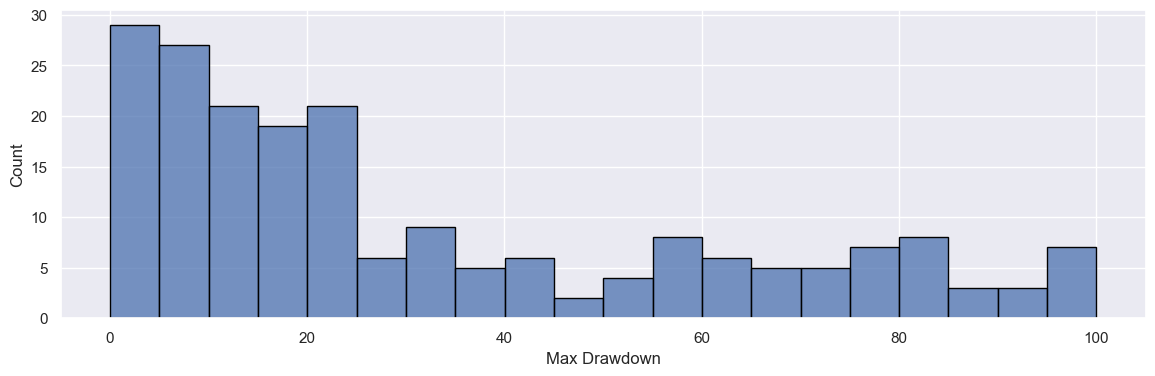

In [33]:
fig, axes = plt.subplots(figsize=(14,4))
sns.histplot(data=df_selected, x='Max Drawdown', bins=20, ec='black');

We are not interested in analyse strategies with a Maximum Drawdown greater than 40%.

In [34]:
index_to_drop = df_selected[df_selected['Max Drawdown'] > max_drawdown_limit].index
df_selected.drop(index_to_drop, axis=0, inplace=True)

# Reset index
df_selected.reset_index(drop=True, inplace=True)

In [35]:
print(f"We have selected {df_selected.shape[0]} strategies to analyze.")

We have selected 141 strategies to analyze.


### Locations

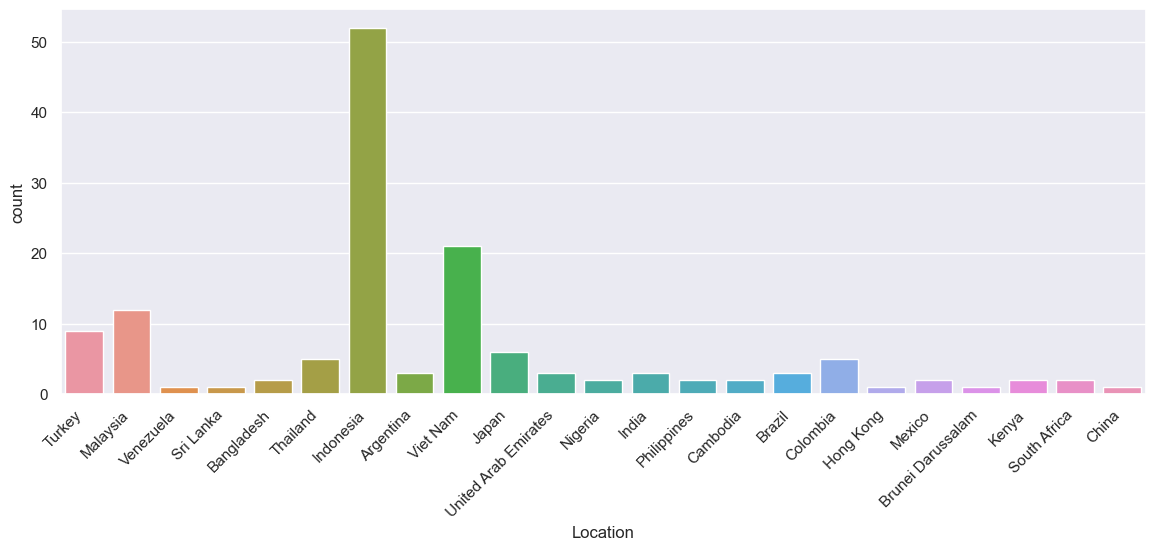

In [36]:
fig, axes = plt.subplots(figsize=(14,5))
bar_plot = sns.countplot(data=df_selected, x='Location', ax=axes)

bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, horizontalalignment='right');

Most of the strategies are in Asia

### Num days strategies

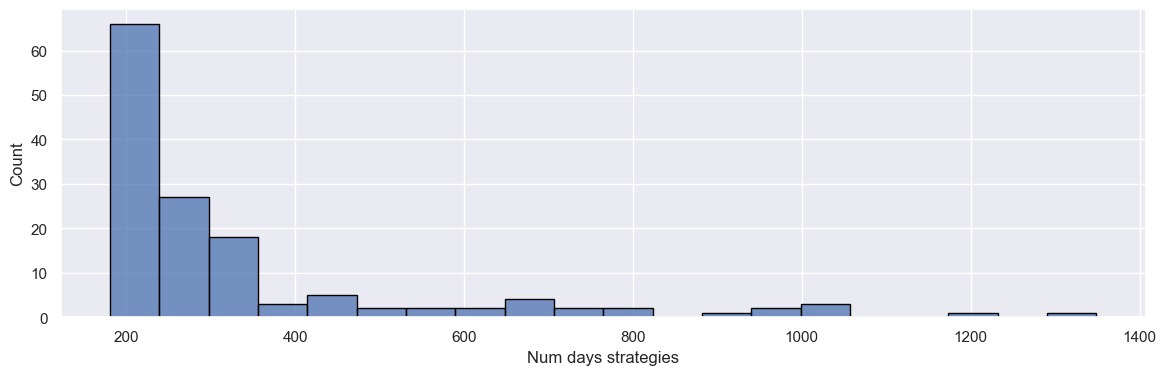

In [37]:
fig, axes = plt.subplots(figsize=(14,4))
sns.histplot(data=df_selected, x='Num days strategies', bins=20, ec='black');

In [38]:
np.histogram_bin_edges(df_selected['Num days strategies'], bins=20, range=None, weights=None)

array([ 181. ,  239.4,  297.8,  356.2,  414.6,  473. ,  531.4,  589.8,
        648.2,  706.6,  765. ,  823.4,  881.8,  940.2,  998.6, 1057. ,
       1115.4, 1173.8, 1232.2, 1290.6, 1349. ])

Most of the strategies with less than two years.

### Followers

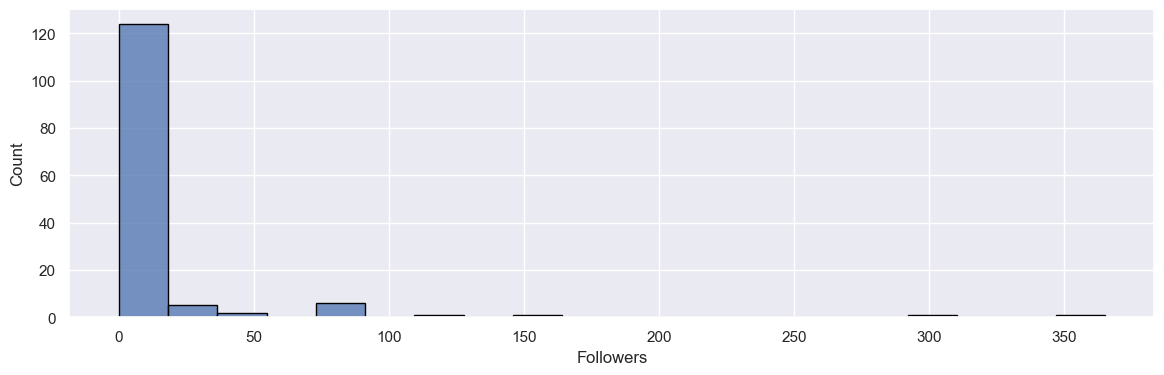

In [39]:
fig, axes = plt.subplots(figsize=(14,4))
sns.histplot(data=df_selected, x='Followers', bins=20, ec='black');

Most of the strategies don't have followers. Only a few strategies have more than 10

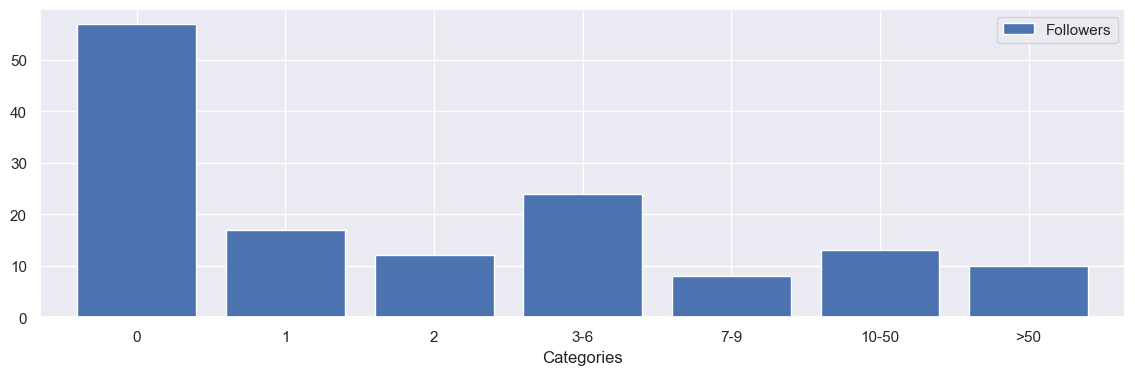

In [40]:
fig, axes = plt.subplots(figsize=(14,4))

temp = pd.DataFrame()
temp['Followers'] = df_selected['Followers']

def find_cat(x):
    if x <= 2:
        return str(int(x))
    elif  3 <= x <= 6:
        return "3-6"
    elif  7 <= x <= 9:
        return "7-9"
    elif  10 <= x <= 50:
        return "10-50"
    elif  x > 50:
        return ">50"

# Apply function to define different categories
temp['Categories'] = temp['Followers'].apply(find_cat)

# Group by new categories
temp = temp.groupby('Categories', as_index=False).count()

# We need to reindex to put the groups in the correct order
temp = temp.reindex(index=[0,1,3,4,5,2,6])

temp.plot.bar(x='Categories', y='Followers', rot=0, width=0.8, ax=axes);

**Observations:**
- Only 13 strategies have between 10 and 50 followers.
- Only 9 strategies have more than 50 followers.

In [41]:
# Define min and max number of followers
num_followers_min, num_followers_max = 10, 50

# Condition to filter DataFrame
condition = (df_selected['Followers'] >= num_followers_min) & (df_selected['Followers'] <= num_followers_max)

print(f"Only {df_selected[condition].shape[0]} strategies between {num_followers_min} and {num_followers_max} followers")

Only 13 strategies between 10 and 50 followers


In [42]:
# Condition to filter DataFrame
condition = df_selected['Followers'] > num_followers_max

print(f"Only {df_selected[condition].shape[0]} strategies with more than {num_followers_max} followers")

Only 10 strategies with more than 50 followers


**For this Notebook, the popular strategies would be with the followers greater than or equal to 10.**

### Performance Fee

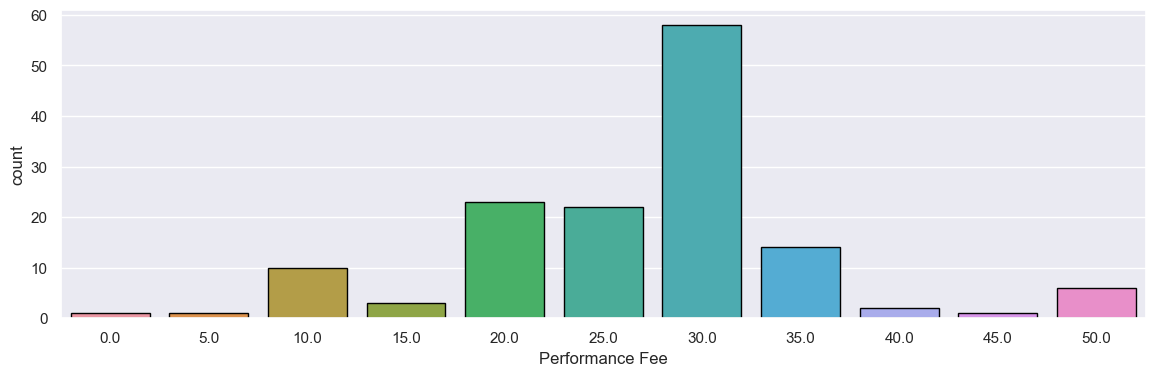

In [43]:
fig, axes = plt.subplots(figsize=(14,4))
sns.countplot(data=df_selected, x='Performance Fee', ec='black');

Most of the strategies requieres 30% of fees.

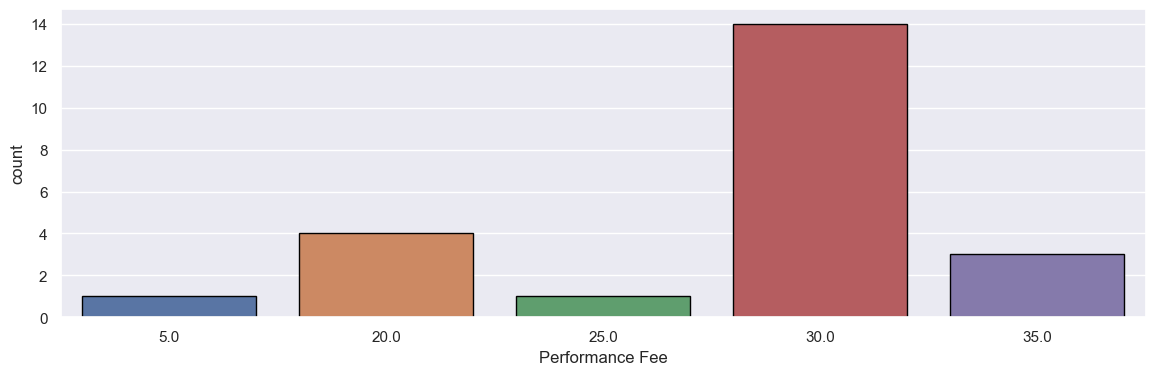

In [44]:
fig, axes = plt.subplots(figsize=(14,4))
sns.countplot(data=df_selected[df_selected['Followers'] >= num_followers_min], x='Performance Fee', ec='black');

The fees distribution of popular stratetegies show a range between 5% - 35%

### Stabililty Score

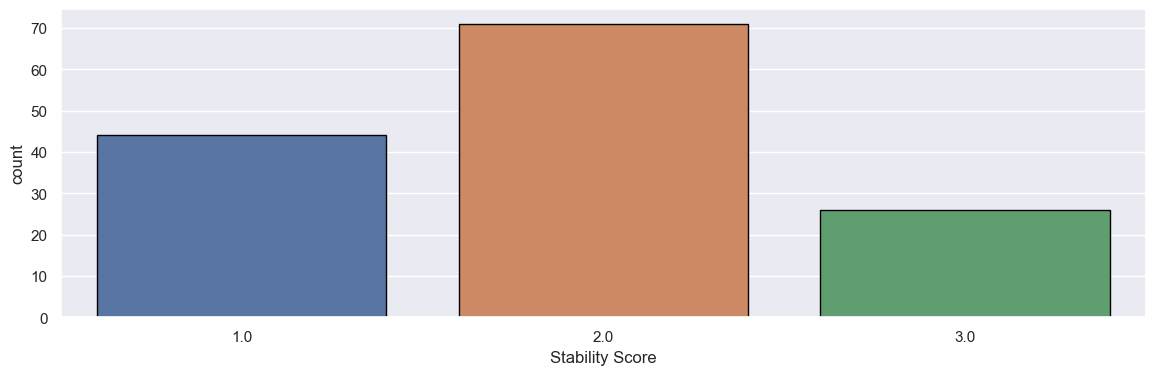

In [45]:
fig, axes = plt.subplots(figsize=(14,4))
sns.countplot(data=df_selected, x='Stability Score', ec='black');

On average, good stability scores.

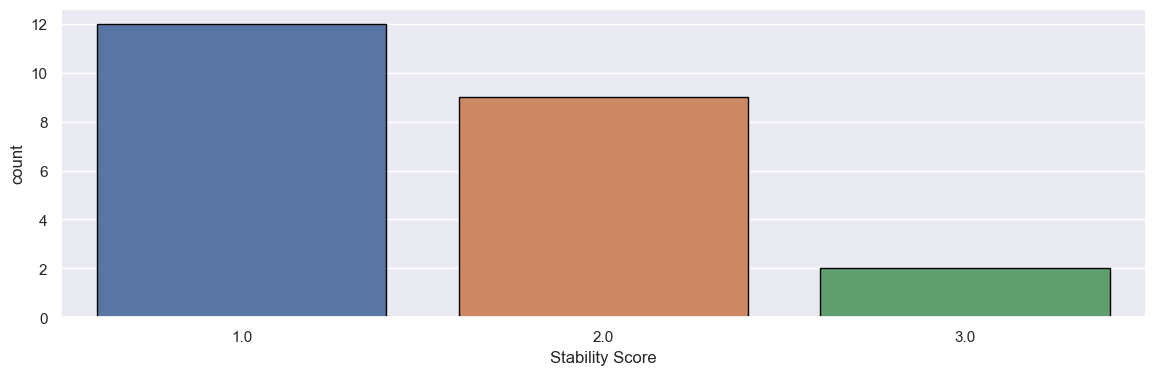

In [46]:
fig, axes = plt.subplots(figsize=(14,4))
sns.countplot(data=df_selected[df_selected['Followers'] >= num_followers_min], x='Stability Score', ec='black');

The popular strategies show a good stability score.

### Performance

In [47]:
# Convert string to dictionary
df_selected['Performance'] = df_selected['Performance'].apply(lambda x: eval(x))

In order to understand the performance percentages, let's select the first user. <a id="performance_example"></a>

The list starts from January to December which the last value is the total of percentage gained by the user. The unit of each number is a percentage.

In [48]:
df_selected.loc[0, 'Performance']

{'2023': [None,
  None,
  None,
  None,
  '3.59',
  '91.12',
  '26.27',
  '21.78',
  '22.41',
  '32.43',
  '19.2',
  '20.35',
  '607.99'],
 '2024': ['10.47',
  '43.9',
  '31.42',
  '9.95',
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  '129.7']}

In [49]:
# Percentage initial
initial = 100

# The user "35378631" is in the position 4.
for item in df_selected.loc[0, 'Performance']['2023'][0:12]: # type: ignore
    if item:
        initial = initial + initial*(float(item)/100)

initial - 100

607.9877559502262

There is a small difference between this value and the last value of dictionary.

The next step is delete the last value of each year list, because we don't need to use the total percentage for the calculations.

In [50]:
df_selected['Performance'].apply(lambda x: [x[key].pop() for key in x.keys()]);

In [51]:
df_selected.loc[0, 'Performance']

{'2023': [None,
  None,
  None,
  None,
  '3.59',
  '91.12',
  '26.27',
  '21.78',
  '22.41',
  '32.43',
  '19.2',
  '20.35'],
 '2024': ['10.47',
  '43.9',
  '31.42',
  '9.95',
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None]}

Check if all rows have data of the current year

In [52]:
# Get years data from dictionaries
years_data = df_selected.loc[:, 'Performance'].apply(lambda x: x.keys())

for item in years_data.index:
    # Print the index if the current year is not in 2024
    if '2024' not in years_data[item]:
        print(item)

54


In [53]:
df_selected.loc[54, 'Performance']

{'2023': [None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  '46.99',
  '3.03',
  None]}

There is one item without 2024 data. Let's delete from data selection

In [54]:
# Drop row without 2024 data.
df_selected.drop(54, axis=0, inplace=True)

# Reset index
df_selected.reset_index(drop=True, inplace=True)

Delete None values of the last 9 months of 2024 because this data was scrapped at the begining of April.

This is an optional and it depends of the scrape date.

In [55]:
for _ in range(9):
    df_selected['Performance'].apply(lambda x: [x['2024'].pop()]);

In [56]:
df_selected.loc[0, 'Performance']

{'2023': [None,
  None,
  None,
  None,
  '3.59',
  '91.12',
  '26.27',
  '21.78',
  '22.41',
  '32.43',
  '19.2',
  '20.35'],
 '2024': ['10.47', '43.9', '31.42']}

Convert string values to float values

In [57]:
def string_to_float(row):
    """
    Convert each list inside dictionary in float values.
    """
    for key in row:
        row[key] = list(map(lambda x: float(x) if x else x, row[key]))

df_selected['Performance'].apply(string_to_float);

In [58]:
df_selected.loc[0, 'Performance']

{'2023': [None,
  None,
  None,
  None,
  3.59,
  91.12,
  26.27,
  21.78,
  22.41,
  32.43,
  19.2,
  20.35],
 '2024': [10.47, 43.9, 31.42]}

### Average Trade Length

Sometimes the row doesn't have hours, minutes or seconds. We need to fix this in order to convert this data to a datetime object.

In [59]:
no_hours = [item for item in  df_selected['Average Trade Length'].index if "H" not in df_selected.loc[item, 'Average Trade Length']]
no_hours

[80, 114]

In [60]:
no_mins = [item for item in  df_selected['Average Trade Length'].index if "m" not in df_selected.loc[item, 'Average Trade Length']]
no_mins

[9, 37, 39, 60, 79, 91]

In [61]:
no_secs = [item for item in  df_selected['Average Trade Length'].index if "s" not in df_selected.loc[item, 'Average Trade Length']]
no_secs

[]

In [62]:
df_selected.loc[no_hours, ['Average Trade Length']]

,Average Trade Length
80,53m 50s
114,40m 35s


In [63]:
df_selected.loc[no_mins, ['Average Trade Length']]

,Average Trade Length
9,14H 0s
37,134H 21s
39,467H 18s
60,20H 6s
79,1H 33s
91,12H 47s


There are some items without hours or minutes data. All items contains "seconds"

In [64]:
# Add "0H" just in case the time string  doesn't have hours data
temp_function = lambda x: '0H ' + x if (not pd.isnull(x)) and ('H' not in x) else x

df_selected['Average Trade Length'] = df_selected['Average Trade Length'].apply(temp_function)

In [65]:
# Add "0m" just in case the time string  doesn't have minutes data
temp_function = lambda x: x.split(" ")[0]  + ' 0m ' + x.split(" ")[1] if (not pd.isnull(x)) and ('m' not in x) else x

df_selected['Average Trade Length'] = df_selected['Average Trade Length'].apply(temp_function)

In [66]:
df_selected.loc[no_hours, ['Average Trade Length']]

,Average Trade Length
80,0H 53m 50s
114,0H 40m 35s


In [67]:
df_selected.loc[no_mins, ['Average Trade Length']]

,Average Trade Length
9,14H 0m 0s
37,134H 0m 21s
39,467H 0m 18s
60,20H 0m 6s
79,1H 0m 33s
91,12H 0m 47s


In [68]:
# Split column
avg_trade_length = df_selected['Average Trade Length'].str.split(' ', expand=True)
avg_trade_length.columns = ['Hours', 'Minutes', 'Seconds']

In [69]:
avg_trade_length.iloc[37:42, :]

,Hours,Minutes,Seconds
37,134H,0m,21s
38,67H,54m,22s
39,467H,0m,18s
40,75H,17m,51s
41,1H,28m,28s


In [70]:
# Remove "H", "m", and "s" from the rows
avg_trade_length['Hours'] = avg_trade_length['Hours'].str.split('H', expand=True)[0]
avg_trade_length['Minutes'] = avg_trade_length['Minutes'].str.split('m', expand=True)[0]
avg_trade_length['Seconds'] = avg_trade_length['Seconds'].str.split('s', expand=True)[0]

In [71]:
avg_trade_length.head()

,Hours,Minutes,Seconds
0,14,45,2
1,16,11,45
2,7,39,42
3,26,29,37
4,13,55,12


In [72]:
# Convert as integer
avg_trade_length = avg_trade_length.astype(int)

# Rename "Average Trade Length". The new unit is in hours
df_selected['Average Trade Length'] = avg_trade_length['Hours'] + avg_trade_length['Minutes'] / 60 + avg_trade_length['Seconds'] / 3600

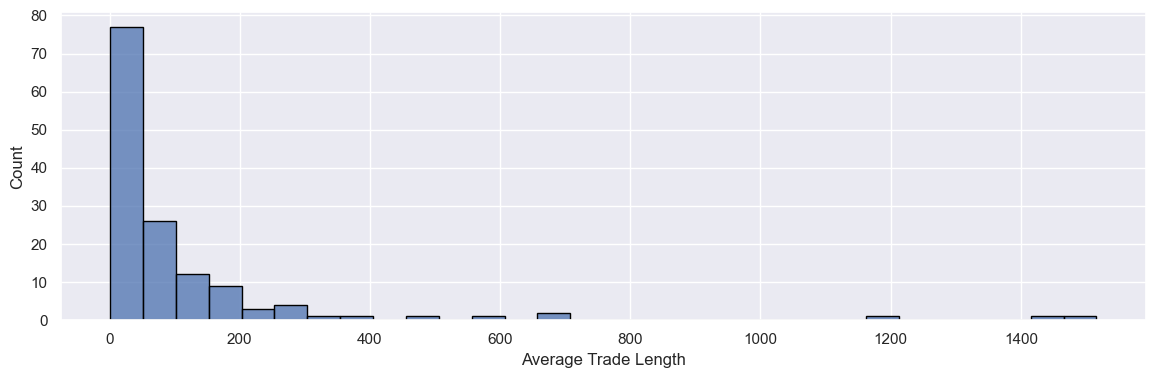

In [73]:
fig, axes = plt.subplots(figsize=(14,4))
sns.histplot(data=df_selected, x='Average Trade Length', bins=30, ec='black');

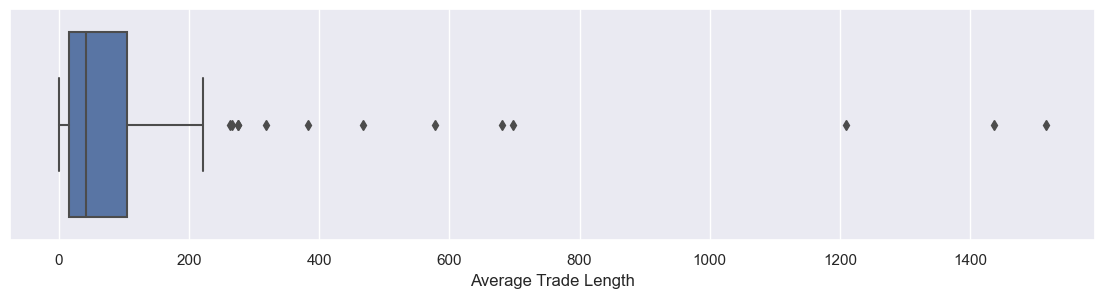

In [74]:
fig, axes = plt.subplots(figsize=(14,3))
sns.boxplot(data=df_selected, x='Average Trade Length');

More than 800 hours implies more than 33 days on average by trade. We wouldn't like to analyse strategies which take a lot of time in one single trade. 

Therefore, we can delete it.

In [75]:
df_selected[df_selected['Average Trade Length'] > 800]

,Provider name,ID,Hotforex url,Location,Last updated,Message,Minimum first deposit,Active since,Gain,Max Drawdown,...,Positive Closed Trades,Negative Closed Trades,Profitability,Average Profit,Average Loss,Average Lot Size,Average Trade Length,Activity,Type account,Num days strategies
83,Afroswingfx,69013120,https://my.hfm.com/en/hfcopy/provider-details....,Kenya,2024-04-18 03:10:40,"""The trading strategy is predominantly based o...",500.0,2022-05-16,16.43,NaN,...,67.0,0.0,100.00,18.82,NaN,0.01,1209.688333,"{'Symbol': ['EURNZD', 'EURGBP', 'GBPUSD', 'GBP...",Premium,702.0
125,daigo_doya,35327998,https://my.hfm.com/en/hfcopy/provider-details....,Japan,2024-04-18 14:01:49,"""Planned averaging. Focus on small lots.mid-te...",25.0,2022-08-23,-25.11,1.7,...,43.0,4.0,91.49,23.85,-11.81,0.01,1516.177778,"{'Symbol': ['USDCHF', 'USDJPY', 'USDJPY', 'USD...",Premium,603.0
136,Saitama,35318794,https://my.hfm.com/en/hfcopy/provider-details....,Indonesia,2024-04-18 14:31:38,"""Scalping, Swing Trading.""",25.0,2022-05-16,-75.29,NaN,...,23.0,0.0,100.00,63.42,NaN,0.01,1436.203333,"{'Symbol': ['XAUUSD', 'XAUUSD', 'XAUUSD', 'XAU...",Premium,702.0


In [76]:
index_to_drop = df_selected[df_selected['Average Trade Length'] > 800].index

# Drop row
df_selected.drop(index_to_drop, axis=0, inplace=True)

# Reset index
df_selected.reset_index(drop=True, inplace=True)

Average trade length between 200 and 600 hours implies between 8 and 25 days.

These are mid term strategies and maybe it could be interesting to copy one of them.

### Profitability

Percentage of closed operations with positive profits:

```python
"Positive Closed Trades" / "Number of Closed Trades".
```


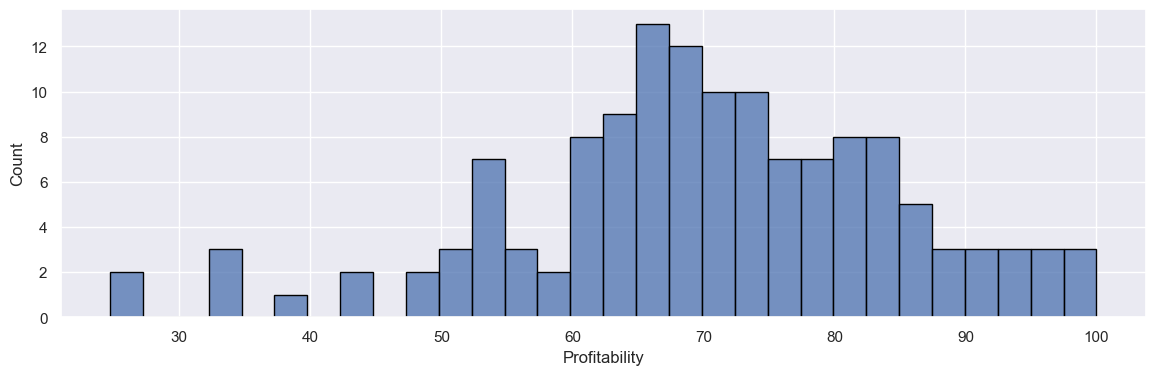

In [77]:
fig, axes = plt.subplots(figsize=(14,4))
sns.histplot(data=df_selected, x='Profitability', bins=30, ec='black');

Most of the strategies have profitability higher than 50%.

### Number of Closed Trades

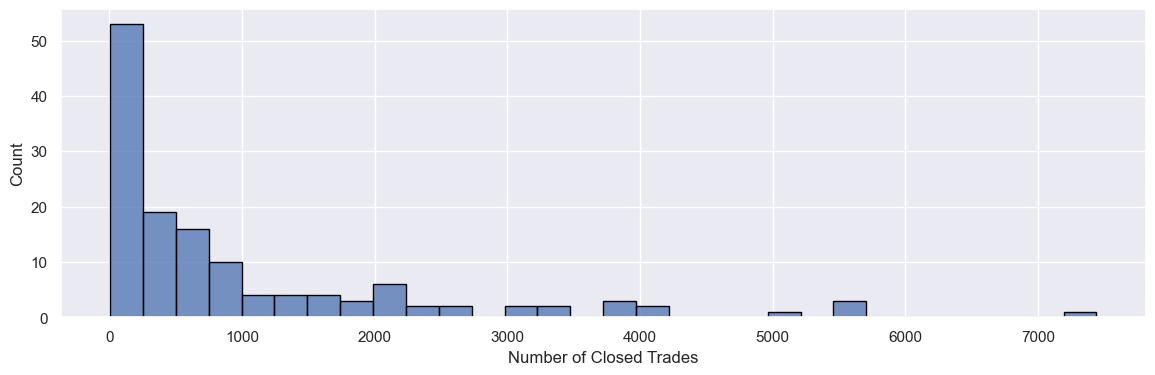

In [78]:
fig, axes = plt.subplots(figsize=(14,4))
sns.histplot(data=df_selected, x='Number of Closed Trades', bins=30, ec='black');

There are strategies with more than 2000 trades.  Therefore, it could be interesting to know the average of trades by day.

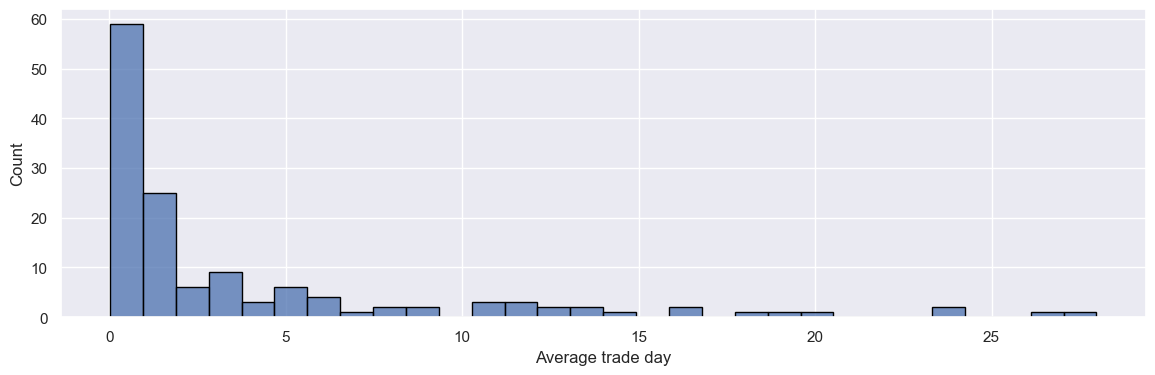

In [79]:
df_selected['Average trade day'] = df_selected['Number of Closed Trades'] / df_selected['Num days strategies']

fig, axes = plt.subplots(figsize=(14,4))
sns.histplot(data=df_selected, x= 'Average trade day', bins=30, ec='black');

There are strategies with more than 10 trades by day. This is a lot of trades in one single day.

In [80]:
condition = df_selected[(df_selected['Average trade day'] >= 10)].index

df_selected.loc[condition, ['Max Drawdown', 'Followers', 'Gain', 'Number of Closed Trades', 'Num days strategies', 'Average trade day']]

,Max Drawdown,Followers,Gain,Number of Closed Trades,Num days strategies,Average trade day
2,24.99,300.0,1169.72,4096.0,247.0,16.582996
22,19.20,0.0,145.43,5147.0,184.0,27.972826
23,20.37,87.0,136.75,5671.0,237.0,23.928270
24,29.51,2.0,167.57,4011.0,249.0,16.108434
31,11.40,4.0,103.97,7440.0,308.0,24.155844
34,15.57,2.0,86.41,3772.0,184.0,20.500000
35,13.25,11.0,84.35,3267.0,220.0,14.850000
43,2.09,0.0,67.18,2089.0,194.0,10.768041
51,4.67,0.0,55.50,2391.0,196.0,12.198980
54,9.04,0.0,56.18,3899.0,343.0,11.367347


It is interesting the strategy in the position 2. Even tough the trader shows an average of 16 trades per day, it shows a huge Gain and an acceptable Max Drawdown.